In [5]:
#https://www.tensorflow.org/tutorials/keras/regression
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

#!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

#!pip list

## Downloading the data set (once)

In [6]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 2us/step


'/Users/benjamin.jones/.keras/datasets/auto-mpg.data'

## Import data using pandas

In [19]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean the data

**This dataset contains some unknown values**

In [20]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

**We'll simply drop the empty rows**

In [21]:
dataset = dataset.dropna()

**the 'Origin' column is categorial, so convert that to a one-hot**

In [22]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## Split into train and test

In [45]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Initial Inspection

**Have a quick look at the joint distribution of a few pairs of columns from the training set**

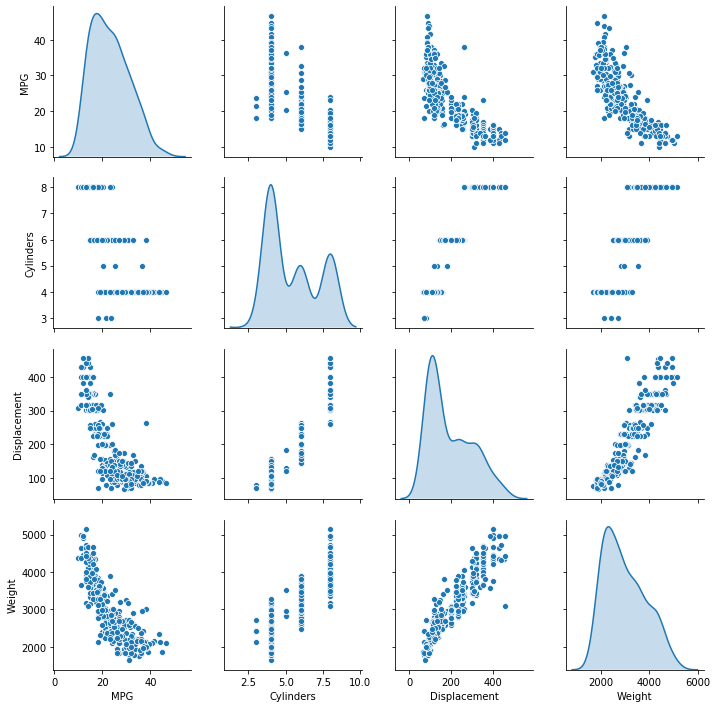

In [46]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

**Overall statistics**

In [47]:
train_stats = train_dataset.describe()
train_stats.pop('MPG') #remove; this is what we're trying to predict
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Split features from labels

**Separate target value, or label, from the features. This label is MPG - what we're tyring to predict**

In [48]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

## Standardization (normalize)

**Ranges for each feature (input) are very different. Standardize (normalize) features that use different scales and ranges. Although the model _might_ converge without feature standirazation, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.**

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [51]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset) #will model based on the z-scores of the data (not the raw data directly)
normed_test_data = norm(test_dataset)

normed_train_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,-0.465148,-0.495225,0.774676
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,-0.465148,-0.495225,0.774676
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,-0.465148,-0.495225,0.774676
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,-0.465148,-0.495225,0.774676
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-0.465148,2.012852,-1.286751


## Model

**Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.**

In [52]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [53]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


**Quickly test model. Appears to be working, producing a result of the expected shape and type.**

In [54]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.19214167],
       [0.10213864],
       [0.18921144],
       [0.3713814 ],
       [0.2358438 ],
       [0.12526812],
       [0.27547848],
       [0.5234838 ],
       [0.00774772],
       [0.31374466]], dtype=float32)

## Training

**Train the model for 1000 epochs, and record the training and validation accuracy in the history object.**

In [55]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:558.6210,  mae:22.3199,  mse:558.6211,  val_loss:550.7519,  val_mae:22.0529,  val_mse:550.7518,  
....................................................................................................
Epoch: 100, loss:6.0339,  mae:1.7154,  mse:6.0339,  val_loss:8.0606,  val_mae:2.1211,  val_mse:8.0606,  
....................................................................................................
Epoch: 200, loss:5.1175,  mae:1.5711,  mse:5.1175,  val_loss:8.0443,  val_mae:2.1700,  val_mse:8.0443,  
....................................................................................................
Epoch: 300, loss:4.5407,  mae:1.4653,  mse:4.5407,  val_loss:8.4990,  val_mae:2.2166,  val_mse:8.4990,  
....................................................................................................
Epoch: 400, loss:4.0924,  mae:1.3404,  mse:4.0924,  val_loss:8.9518,  val_mae:2.2806,  val_mse:8.9518,  
..............................................................

**Visualize the model's training progress using the stats stored in the history object.**

In [56]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.451955,1.014602,2.451955,10.607991,2.436026,10.607991,995
996,2.732804,1.096705,2.732804,10.272641,2.368540,10.272641,996
997,2.492213,1.058735,2.492213,10.627373,2.462861,10.627374,997
998,2.498326,1.032418,2.498326,10.744113,2.456325,10.744113,998
999,2.438891,1.035317,2.438891,11.067343,2.519943,11.067343,999


Text(0, 0.5, 'MAE [MPG]')

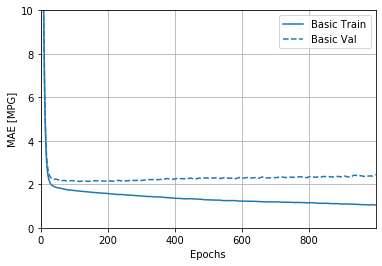

In [57]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

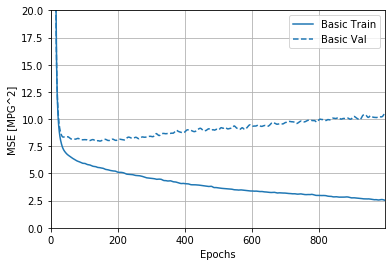

In [58]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

**This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the model.fit call to automatically stop training when the validation score doesn't improve. We'll use an EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.**

In [59]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:569.5600,  mae:22.6131,  mse:569.5600,  val_loss:557.5456,  val_mae:22.3437,  val_mse:557.5456,  
................................................................

Text(0, 0.5, 'MAE [MPG]')

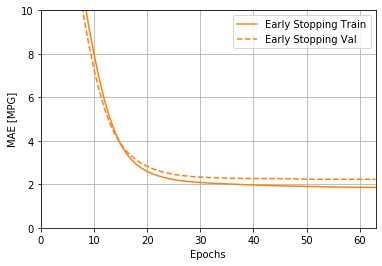

In [60]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

**The graph shows that on the validation set, the average error is usually around +/- 2 MPG.**

**Let's see how well the model generalizes by using the test set, which we did not use when training the model. This tells us how well we can expect the model to predict when we use it in the real world.**

In [61]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.7370 - mae: 1.8323 - mse: 5.7370
Testing set Mean Abs Error:  1.83 MPG


## Make Predictions

**Lastly, predict MPG values using testing data**

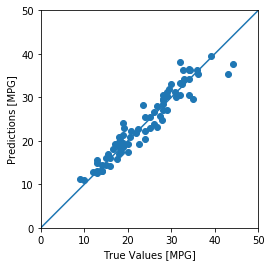

In [62]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


**Looking at error distribution:**

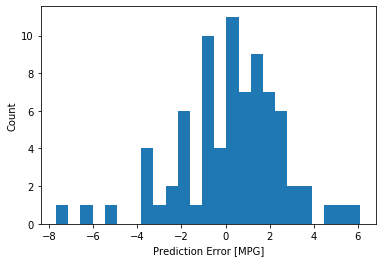

In [63]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

## Conclusion

**Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).**

**Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).**

**When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.**

**If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.**

**Early stopping is a useful technique to prevent overfitting.**